In [4]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [5]:
data = pd.read_excel("data.xlsx",header=1)

In [6]:
data

,Al,Ca,Cu,Fe,K,Mg,Mn,Na,Zn,grouped,tea,Concentration,time,teaConc,tea_org,tea_var
0,3.297,4.356,0.031290,0.067,99.06,3.531,1.455,0.541,0.131,Black Turkish 1 2,BT,1,2,BT1,black,turki
1,4.267,4.118,0.031290,0.079,106.50,3.378,1.542,0.603,0.126,Black Turkish 1 2,BT,1,2,BT1,black,turki
2,4.088,4.763,0.033370,0.084,114.00,4.763,1.838,1.058,0.156,Black Turkish 1 5,BT,1,5,BT1,black,turki
3,4.338,4.556,0.033370,0.091,122.60,5.005,2.269,0.958,0.162,Black Turkish 1 5,BT,1,5,BT1,black,turki
4,4.732,5.138,0.035514,0.110,132.40,5.626,2.998,1.510,0.165,Black Turkish 1 10,BT,1,10,BT1,black,turki
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,16.690,8.895,0.153000,0.236,323.40,20.450,10.420,6.360,0.335,Green Ceylan 3 30,GC,3,30,GC3,green,ceylon
164,17.620,8.909,0.177000,0.261,334.20,23.486,11.330,7.133,0.351,Green Ceylan 3 45,GC,3,45,GC3,green,ceylon
165,17.920,9.056,0.180000,0.266,332.30,22.840,11.290,7.609,0.358,Green Ceylan 3 45,GC,3,45,GC3,green,ceylon
166,17.820,9.128,0.175000,0.273,367.30,24.560,12.110,8.537,0.372,Green Ceylan 3 60,GC,3,60,GC3,green,ceylon


In [7]:
# カテゴリ変数のOne-Hotエンコーディング
encoder = OneHotEncoder()
encoded_tea = encoder.fit_transform(data[["tea"]]).toarray()
data = pd.concat([data, pd.DataFrame(encoded_tea, columns=encoder.get_feature_names_out())], axis=1)
data.drop("tea", axis=1, inplace=True)

# 説明変数と目的変数の分割
X = data.drop(["Al", "Ca", "Cu", "Fe", "K", "Mg", "Mn", "Na", "Zn","grouped","teaConc","tea_org","tea_var"], axis=1)
y = data[["Al", "Ca", "Cu", "Fe", "K", "Mg", "Mn", "Na", "Zn"]]

# 標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X_scaled, 
                                                    y, 
                                                    test_size=0.1, 
                                                    random_state=42
                                                   )

In [8]:
X

,Concentration,time,tea_BC,tea_BT,tea_GC,tea_GT
0,1,2,0.0,1.0,0.0,0.0
1,1,2,0.0,1.0,0.0,0.0
2,1,5,0.0,1.0,0.0,0.0
3,1,5,0.0,1.0,0.0,0.0
4,1,10,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...
163,3,30,0.0,0.0,1.0,0.0
164,3,45,0.0,0.0,1.0,0.0
165,3,45,0.0,0.0,1.0,0.0
166,3,60,0.0,0.0,1.0,0.0


In [9]:
y_train['Fe']

109    0.164
75     0.080
108    0.174
19     0.155
16     0.137
       ...  
71     0.059
106    0.157
14     0.093
92     0.115
102    0.132
Name: Fe, Length: 151, dtype: float64

In [10]:
# MLRモデルの構築
model = LinearRegression()
model.fit(X_train, y_train['Fe'])

LinearRegression()

In [13]:
import optuna

import logging

# ログレベルをWARNINGに設定 (INFO以下のログを出力しない)
logging.basicConfig(level=logging.WARNING)

In [14]:
def objective(trial):
    # 試行回数から濃度と時間をサンプリング
    concentration = trial.suggest_float("concentration", 0.1, 3.0)
    time = trial.suggest_int("time", 2, 60)

    # 新しいデータを作成
    new_data = np.array([[concentration, time, 0, 0, 0,1]])  # BTの場合
    new_data_scaled = scaler.transform(new_data)

    # モデルで予測
    predicted_fe = model.predict(new_data_scaled)[0]

    # Feの抽出量を最大化したいので、負の値を返す
    return -predicted_fe

# Optunaのスタディを作成
study = optuna.create_study(direction="minimize")

# 最適化の実行
study.optimize(objective, n_trials=500)

# 最適なパラメータ
best_params = study.best_params
print(best_params)

[I 2024-08-15 22:40:50,012] A new study created in memory with name: no-name-3b288641-6d5e-47ef-87e9-d1664551cd84
C:\Users\Matsunami\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2024-08-15 22:40:50,020] Trial 0 finished with value: -0.1610291213851713 and parameters: {'concentration': 1.7173501398041042, 'time': 36}. Best is trial 0 with value: -0.1610291213851713.
C:\Users\Matsunami\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
[I 2024-08-15 22:40:50,023] Trial 1 finished with value: -0.1039002151351713 and parameters: {'concentration': 1.0156920448843234, 'time': 15}. Best is trial 0 with value: -0.1610291213851713.
C:\Users\Matsunami\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardSc

{'concentration': 2.9963586083516143, 'time': 60}


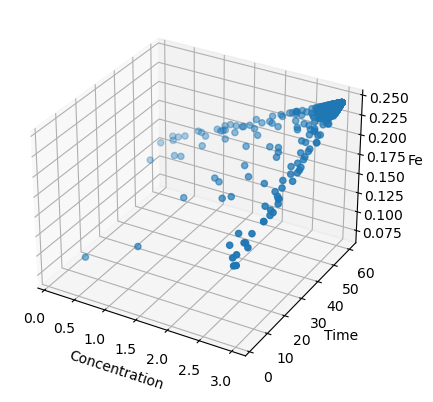

In [15]:
# 試行回数とFeの抽出量のグラフ
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

optuna.visualization.plot_optimization_history(study)
plt.show()

# 濃度と時間、Feの抽出量の3Dプロット
def plot_3d(study):
    df = study.trials_dataframe()
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(df['params_concentration'], df['params_time'], -df['value'])
    ax.set_xlabel('Concentration')
    ax.set_ylabel('Time')
    ax.set_zlabel('Fe')
    plt.show()

plot_3d(study)

In [16]:
# MLRモデル
def create_mlr_model(y_column):
    model = LinearRegression()
    model.fit(X_train, y_train[y_column])
    return model

# ANNモデル
def create_ann_model(y_column):
    model = Sequential()
    model.add(Dense(18, activation='leaky_relu', input_dim=X_train.shape[1]))
    model.add(Dense(8, activation='leaky_relu'))
    model.add(Dense(12, activation='leaky_relu'))
    model.add(Dense(18, activation='leaky_relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer=Adam())
    model.fit(X_train, y_train[y_column], epochs=100, verbose=0)
    return model

In [ ]:
# 各目的変数に対するモデル作成と評価
for column in y.columns:
    print(f"Target variable: {column}")

    # MLRモデル
    mlr_model = create_mlr_model(column)
    y_pred_mlr = mlr_model.predict(X_test)
    print("MLR:")
    print(f"R2 score: {r2_score(y_test[column], y_pred_mlr)}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test[column], y_pred_mlr))}")
    print(f"MAE: {mean_absolute_error(y_test[column], y_pred_mlr)}")

    # ANNモデル
    ann_model = create_ann_model(column)
    y_pred_ann = ann_model.predict(X_test)
    print("ANN:")
    print(f"R2 score: {r2_score(y_test[column], y_pred_ann)}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test[column], y_pred_ann))}")
    print(f"MAE: {mean_absolute_error(y_test[column], y_pred_ann)}")

Target variable: Al
MLR:
R2 score: 0.8349225243787823
RMSE: 2.1075123495281805
MAE: 1.7374127817423601


C:\Users\Matsunami\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

